<a href="https://colab.research.google.com/github/guoguolee88/Histopathologic-Cancer_Detection/blob/master/KAGGLE_CANCER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training a convnet from scratch on a small - Histopathologic Cancer Detection

### The relevance of deep learning for small-data problems

### Downloading the data

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

Navigate to the Kaggle website (https://www.kaggle.com/) in a web browser, log in, and go to the My Account page. In your account settings, you’ll find an API section. Clicking the Create New API Token button will generate a kaggle.json key file and will download it to your machine.

Then go to your Colab notebook, and upload the API’s key JSON file to your Colab session by running the following code in a notebook cell:

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"guoguolee88","key":"acdf2da2a09af0681428c0f643dd95b7"}'}

you will see a Choose Files button appear. Click it and select the **kaggle.json** file you just downloaded. This uploads the file to the local Colab runtime.

In [ ]:
!pip install -U -q kaggle
!mkdir ~/.kaggle # make directory 
!cp kaggle.json ~/.kaggle/ # copy the file
!chmod 600 ~/.kaggle/kaggle.json # change permissions on API key file make it only readable to yourself 

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [00:48<00:00, 137MB/s]
100% 6.31G/6.31G [00:48<00:00, 140MB/s]


In [ ]:
!unzip -qq histopathologic-cancer-detection.zip


replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
!unzip -qq train.zip

unzip:  cannot find or open train.zip, train.zip.zip or train.zip.ZIP.


**Copying images to training, validation, and test directories**

In [ ]:

import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("hitstopathologic-cancer-detection")

def make_subset(subset_name, start_index, end_index):
    for category in ("0", "1"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

In [ ]:
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

FileExistsError: ignored

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3)) # 180 X 180 X 3 (color)
x = layers.Rescaling(1./255)(inputs) # scale to [0,1]
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x) # depth of the feature map increases
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # binary classifier 
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

**Configuring the model for training**

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 0 files belonging to 1 classes.


ValueError: ignored

In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 14s 76ms/step - loss: 0.8054 - accuracy: 0.5090 - val_loss: 0.6920 - val_accuracy: 0.5390
Epoch 2/30
63/63 [==============================] - 4s 64ms/step - loss: 0.7242 - accuracy: 0.5295 - val_loss: 0.6809 - val_accuracy: 0.5500
Epoch 3/30
63/63 [==============================] - 4s 63ms/step - loss: 0.7084 - accuracy: 0.5865 - val_loss: 0.6531 - val_accuracy: 0.5730
Epoch 4/30
63/63 [==============================] - 4s 63ms/step - loss: 0.6637 - accuracy: 0.6315 - val_loss: 0.6532 - val_accuracy: 0.5950
Epoch 5/30
63/63 [==============================] - 4s 65ms/step - loss: 0.6176 - accuracy: 0.6690 - val_loss: 0.6101 - val_accuracy: 0.6790
Epoch 6/30
63/63 [==============================] - 4s 64ms/step - loss: 0.5742 - accuracy: 0.7130 - val_loss: 0.6840 - val_accuracy: 0.6730
Epoch 7/30
63/63 [==============================] - 4s 64ms/step - loss: 0.5221 - accuracy: 0.7490 - val_loss: 0.6546 - val_accuracy: 0.6720
Epoch 8/30
6

**Displaying curves of loss and accuracy during training**

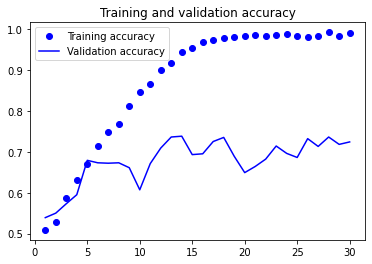

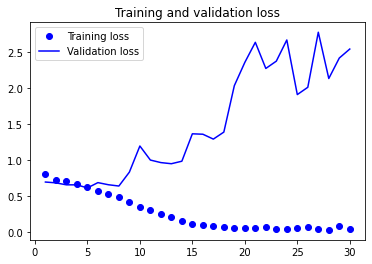

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 35ms/step - loss: 0.6104 - accuracy: 0.6830
Test accuracy: 0.683


### Using data augmentation

**Define a data augmentation stage to add to an image model**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

**Displaying some randomly augmented training images**

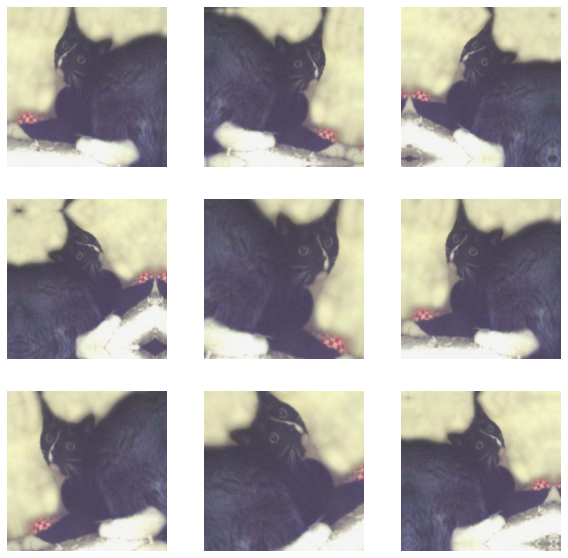

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**Defining a new convnet that includes image augmentation and dropout**

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x) # The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

**Training the regularized convnet**

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 7s 94ms/step - loss: 0.7088 - accuracy: 0.4995 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 6s 91ms/step - loss: 0.6998 - accuracy: 0.5240 - val_loss: 0.6848 - val_accuracy: 0.5650
Epoch 3/100
63/63 [==============================] - 6s 91ms/step - loss: 0.6796 - accuracy: 0.5665 - val_loss: 0.6473 - val_accuracy: 0.6380
Epoch 4/100
63/63 [==============================] - 6s 93ms/step - loss: 0.6923 - accuracy: 0.6155 - val_loss: 0.6569 - val_accuracy: 0.5680
Epoch 5/100
63/63 [==============================] - 6s 91ms/step - loss: 0.6371 - accuracy: 0.6330 - val_loss: 0.6381 - val_accuracy: 0.6320
Epoch 6/100
63/63 [==============================] - 6s 92ms/step - loss: 0.6408 - accuracy: 0.6265 - val_loss: 0.6449 - val_accuracy: 0.6160
Epoch 7/100
63/63 [==============================] - 6s 89ms/step - loss: 0.6192 - accuracy: 0.6540 - val_loss: 0.6083 - val_accuracy: 0.6480
Epoch 

**Evaluating the model on the test set**

In [ ]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 2s 34ms/step - loss: 0.4615 - accuracy: 0.7800
Test accuracy: 0.780
